# Pricing American Options with Montecarlo #

### Part 2 - Random Tree Methods ###

In [3]:
import math
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import scipy.stats       as ss

%matplotlib inline

# local module
import ACF_utils
from ACF_utils.Trees import random_tree

In [4]:
#Black and Scholes
def d1(S0, K, r, delta, sigma, T):
    return (np.log(S0/K) + 
            (r - delta + sigma**2 / 2) * T)/(sigma * np.sqrt(T))
 
def d2(S0, K, r, delta, sigma, T):
    return (np.log(S0 / K) + 
            (r - delta - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
 
def BlackScholes(payout, S0, K, r, delta, sigma, T):
    if payout==1:
        return S0 * np.exp(-delta * T) * ss.norm.cdf(d1(S0, K, r, delta, sigma, T)) \
               - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, delta, sigma, T))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, delta, sigma, T)) \
               - S0 * np.exp(-delta*T) * ss.norm.cdf(-d1(S0, K, r, delta, sigma, T))

## Introduction ##

As we have already said, the major difficulty in valuing assets with early exercise features is the need to estimate an optimal exercise policy. Generally, pricing methods for these assets are backward algorithms. Starting from maturity where the optimal exercise policy is known the algorithm proceeds backward in time and calculates the optimal exercise strategy and the corresponding price via dynamic programming.

An important topic that will be discussed is the analysis of the sources of high and low bias that affect all methods for pricing American options by simulation. High bias results from using information about the future in exercise decisions, and this is the result of applying backward induction to the simulated paths. Low bias is the direct result of following a sub-optimal exercise strategy. Some methods mix the two sources of bias, but we will see that by separating them it is often possible to produce a pair of estimates containing the optimal value.

In discussing simulation methods for pricing American options we restrict ourselves to options that can be exercised only at fixed set of exercise opportunities $t_1 < t_2 < \dots < t_m$. In some cases such a restriction is part of the option contract (Bermudan options); in others it is known in advance that exercise is suboptimal at all but a finite set of dates, such as dividend payment dates. One may alternatively view the restriction to a finite set of exercise dates as an approximation to a contract allowing continuous exercise, in which case one would want to consider the effect of letting $m$ increase to infinity. Because even the finite-exercise problem poses a significant challenge to Monte Carlo we focus exclusively on this case.

In this lesson we most follow the Paul Glasserman’s book, *"Monte Carlo Methods in Financial Engineering"* (Springer, 2004). Chapter 8 ("Pricing American Option") is used for basic deﬁnitions, formulations and some tips for approximations of values and stopping rules.

## Broadie and Glasserman Approach ##

Broadie and Glasserman (1997) argued that *there can be no general method for producing unbiased simulation estimators of American option values*. For this reason they suggest to use two estimates of the asset price based on random samples of future state trajectories and increasingly refined approximations to optimal exercise decisions. Both estimates are biased, one high and the other low, however they are asymptotically unbiased and converge to the true price. A combination of two biased estimators can be almost as effective as a single unbiased one. Imagine that $\hat\Theta(b)$ and $\hat\theta(b)$ are each sample means of $n$ independent replications for each value of a simulation parameter $b$ and they are respectively biased high and low

\begin{equation}
E\left[\hat\Theta(b)\right] \ge V_0 \ge E\left[\hat\theta(b)\right]
\end{equation}

if for some halfwidth $H_n(b)$

\begin{equation}
\hat\Theta(b) \pm H_n(b)
\end{equation}

is a valid $95$% confidence interval for $E\left[\hat\Theta(b)\right] $ and if 

\begin{equation}
\hat\theta(b) \pm L_n(b)
\end{equation}

is a valid $95$ percent confidence interval for $E\left[\hat\theta(b)\right]$, then by using the lower limit of the low estimator and the upper limit of the high estimator it is possible to construct the confidence interval

\begin{equation}
\left( 
\hat\theta(b) - L_n(b), \hat\Theta(b) + H_n(b)
\right)
\end{equation}

containing the unknown value $V_0$ with probability at least $90$ percent. Moreover the confidence interval may be shrunk to the point $V_0$ in the limit as the computational effort grows because the inequalities in (2.9) become equalities as $b \rightarrow \infty$ and the interval halfwidths $H_n(b)$ and $L_n(b)$ go to zero as $n \rightarrow \infty$. Thus combining the two estimates it is possible to obtain a confidence interval for the asset price.

## What is a Random Tree ##

These methods try to estimate the value based on some generated random trees (in which the tree has the height equal to for example $n$ and each internal nodes have $b \ge 2$ children)

<div>
<img src="img/lesson_1/stochastic_tree_1.PNG",width="400",height="300">
</div>

The main shortcoming of the stochastic tree is that its computational requirements grow exponentially in the number of exercise dates $m$, so the method is best applicable when $m$ is small. *<u>Nevertheless the discussion of this method serves to illustrate a main theme of the montecarlo simulation applied to early exercise problem: managing sources of high and low bias</u>*.

## Constructing the tree ##

For simulating a random trajectory of stock price from time $0$ to maturity time $T$, ﬁrst we divide the time interval and by starting from the stock price at time 0, we randomly (according to the dynamics of the underlying asset’s price) determine the stock price at next time step and we continue in this manner until maturity time. We start from the root of the tree, labeling it with the initial stock price, $S_0$. Then we simulate the next stock price according to initial price independently $b$ times, calling them $S_1^1 , S_1^2 , \dots, S_1^b$ , and we use them to label children of the root. From each of $S_1^i$’s we simulate new stock price according to their parent’s stock price. 

So for example $S_1^{i1} , S_1^{i2}, \dots, S_1^{ib}$ will be simulated based on $S_1^i$ independently and they will be used to label children of the node with label $S_1^i$. We continue until we reach leaves in the tree (after $n$ steps). So labels of leaves will be like 
$S_n^{i_1 i_2 \dots i_n} (1 \le i, j \le b$ for all $1 \le j \le n$).

Let's see immediately an implementation in Python...

In [5]:
# Simulation Parameters
b  = 3                     # branching parameter
n  = 1                     # Monte Carlo reiterations
t  = [0.,1./3.,2./3.,1.]   # exercise opportunities
dt = t[1]-t[0]

# Financial Parameters
S0     = 100.0   # initial stock level
K      = 100.0   # strike price
T      =   1.0   # time-to-maturity
r      =   0.00  # short rate
sigma  =   0.20  # volatility
delta  =   0.0   # dividend yield
payout =   1     # put option 

In [6]:
#
# Random numbers generations. We use the function 'randn' which returns 
# a sample (or samples) from the "standard normal" distribution.
# If positive, int_like or int-convertible arguments are provided,
# 'randn' generates an array of shape (d0, d1, ..., dn), filled
# with random floats sampled from a univariate "normal" (Gaussian)
# distribution of mean 0 and variance 1
#
z1  = np.random.randn(b, n)
#
# first exercise data 
#
S1 = S0 * np.exp((r - delta - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * z1)
#
# second exercise data 
#
# note that the first parameter is set to 0 since this is the
# dimension along which we want to aggregate results
# 
S2    = np.empty((0, n))    
for i in range(0, b):
    z2     = np.random.randn(b, n)
    S2     = np.append(S2, S1[i,:] * np.exp((r - delta - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * z2), axis=0)

In [7]:
if b < 10: print(S1)

[[95.75541948]
 [99.42517296]
 [88.80720411]]


In [8]:
if b < 10: print(S2)

[[ 89.06332754]
 [111.61372208]
 [109.74930949]
 [108.20076244]
 [116.21873306]
 [118.42449503]
 [ 84.56703542]
 [105.37893803]
 [100.35436924]]


In [9]:
labels = ["%.2f" % S0]
labels.extend(["%.2f" % s for s in list(S1[:,0])])
labels.extend(["%.2f" % s + " [" + str("%.2f" % max(K-s,0)) + "]" for s in list(S2[:,0])])
labels.extend(1000*['ND'])

### Drawing a Non Recombing Tree ###

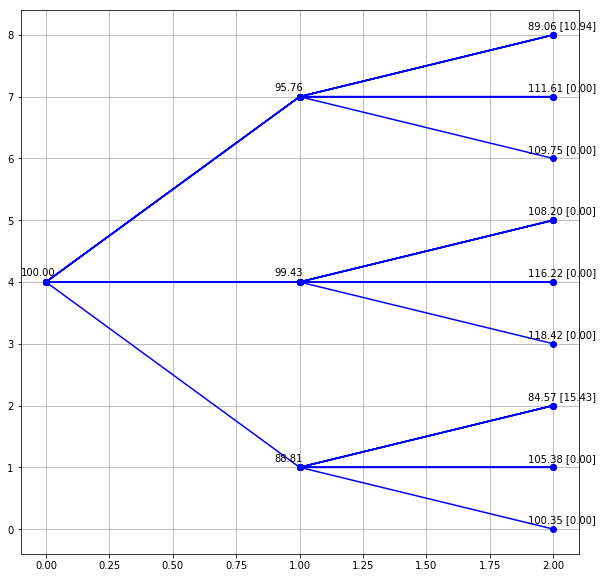

In [10]:
random_tree(b, labels)

## High Estimator ##

The high estimator is defined as the option value estimated using a dynamic programming algorithm to the simulated stochastic tree. The option value is known with certainty at the terminal date. Then, at each prior date, the option value is calculated as the maximum of the immediate exercise value and the expectation of the succeeding discounted option values. The estimator is finally equal to the estimated option value at the initial node.

\begin{equation}
\hat V^{j_1\dots j_m}_m = h_m\left( X_m^{j_1\dots j_m} \right)
\end{equation}

working backward we then set

\begin{equation}
\hat V^{j_1\dots j_i}_i = 
\max \Biggl\{
h_i\left( X_i^{j_1\dots j_i} \right),
\frac{1}{b} \sum\limits_{j=1}^b DF_{i+1}^{j_1\dots j_{i_j}}
\hat V_{i+1}^{j_1\dots j_{i_j}}
\Biggr\}
\end{equation}

In other words, the high estimator is simply the result of applying ordinary dynamic programming to the random tree, assigning equal weight to each branch.

A simple induction argument demonstrates that the high estimator is indeed biased high at every node, in the sense that
$$
\mathbb{E} \left[\hat{V}_i^{j_1,\dots,j_i} \vert X_i^{j_1,\dots,j_i} \right]  \ge V_{i}
\left( X_{i}^{j_1,\dots,j_i} \right) 
$$

First observe that this holds (with equality) at every terminal node because of the payoff function. Now we show that if this equation holds at $i+1$ it holds at $i$:

$$
\mathbb{E} \left[\hat{V}_i^{j_1,\dots,j_i} \vert X_i^{j_1,\dots,j_i} \right]  = 
\mathbb{E} \left[\max\left\{ h_i\left(X_i^{j_1,\dots,j_i}\right), \frac{1}{b} \sum\limits_{j=1}^b
\hat{V}_{i+1}^{j_1\dots j_{i_j}} \right\} \vert X_i^{j_1,\dots,j_i} \right] 
$$

Jensen's inequality states that, if 𝜙 is a convex function then 𝜙(𝔼𝑋) ≤ 𝔼𝜙(𝑋) and since the $max$ *is* a convex function we can write 

$$
\mathbb{E} \left[\hat{V}_i^{j_1,\dots,j_i} \vert X_i^{j_1,\dots,j_i} \right]  \ge 
\max\left\{ h_i\left(X_i^{j_1,\dots,j_i}\right), \mathbb{E}  \left[ \frac{1}{b} \sum\limits_{j=1}^b
\hat{V}_{i+1}^{j_1\dots j_{i_j}} \vert X_i^{j_1,\dots,j_i} \right]\right\} 
$$

now, note that, conditionally to the value of the $ith$ node, the $b$ successors are by construction independent and identically distributed (i.i.d.), so we have 

$$
\mathbb{E} \left[ \frac{1}{b} \sum\limits_{j=1}^b
\hat{V}_{i+1}^{j_1\dots j_{i_j}} \vert X_i^{j_1,\dots,j_i} \right] =
\frac{1}{b} \sum\limits_{j=1}^b \mathbb{E} \left[\hat{V}_{i+1}^{j_1\dots j_{i_j}} \vert X_i^{j_1,\dots,j_i} \right]
=
\mathbb{E} \left[\hat{V}_{i+1}^{j_1\dots j_{i_1}} \vert X_i^{j_1,\dots,j_i} \right]
$$

so

$$
\mathbb{E} \left[\hat{V}_i^{j_1,\dots,j_i} \vert X_i^{j_1,\dots,j_i} \right]  \ge 
\max\left\{ 
h_i\left(X_i^{j_1,\dots,j_i}\right), 
\mathbb{E} \left[\hat{V}_{i+1}^{j_1\dots j_{i_1}} \vert X_i^{j_1,\dots,j_i} \right]
\right\} 
$$

Using the induction hypotesis at $i+1$ is equivalent to say that

$$
\mathbb{E} \left[\hat{V}_{i+1}^{j_1,\dots,j_i} \vert X_i^{j_1,\dots,j_i} \right]  \ge V_{i+1}
\left( X_{i+1}^{j_1,\dots,j_i} \right)  \Rightarrow \mathbb{E} \left[\hat{V}_{i+1}^{j_1,\dots,j_i} \vert X_i^{j_1,\dots,j_i} \right]  \ge \mathbb{E} \left[V_{i+1}
\left( X_{i+1}^{j_1,\dots,j_i} \right) \vert X_i^{j_1,\dots,j_i} \right] 
$$

using this we can write 

$$
\mathbb{E} \left[\hat{V}_i^{j_1,\dots,j_i} \vert X_i^{j_1,\dots,j_i} \right]  \ge 
\max\left\{ 
h_i\left(X_i^{j_1,\dots,j_i}\right), 
\mathbb{E} \left[V_{i+1}
\left( X_{i+1}^{j_1,\dots,j_i} \right) \vert X_i^{j_1,\dots,j_i} \right]
\right\} 
=
V_{i}
\left( X_{i}^{j_1,\dots,j_i} \right) 
$$

and this conclude the demonstration.

### Python Implementation of High Estimator ###

In [11]:
S0     =  90.0   # initial stock level
K      = 100.0   # strike price
T      =   1.0   # time-to-maturity
r      =   0.05  # short rate
sigma  =   0.20  # volatility
delta  =   0.0   # dividend yield
payout =   -1     # put option 

In [12]:
# Simulation Parameters
b  = 30                    # branching parameter 
n  = 5000                  # Monte Carlo reiterations
t  = [0.,1./3.,2./3.,1.]   # exercise opportunities
dt = t[1]-t[0]
df = math.exp(-r * dt)

european_option = BlackScholes(payout, S0, K, r, delta, sigma, T)

Ipotizziamo che esistano solo due opportunità di esercizio come rappresentato nel grafico seguente

<div>
<img src="img/lesson_1/bermudan_exercise_3.PNG",width="600",height="500">
</div>

In [13]:
# Tree Generation
#
z1  = np.random.randn(b, n)
#
# first exercise data 
#
S1 = S0 * np.exp((r - delta - 0.5 * sigma ** 2) * dt 
                 + sigma * math.sqrt(dt) * z1)
#
# second exercise data 
# 
S2  = np.empty((0, n))
S2b = [[] for i in range(0,b)]
    
for i in range(0, b):
    z2  = np.random.randn(b,n)
    S2b[i] = S1[i,:] * np.exp((r - delta - 0.5 * sigma ** 2) * dt 
                              + sigma * math.sqrt(dt) * z2)
    S2     = np.append(S2, S2b[i], axis=0)

When we consider the penultimate exercise opportunity, at $t=t_2$, also in this case the optimal decision depends on which is greater between the immediate exercise value and the continuation value but at this specific time the continuation value is just equal to the price of a European option initiated at time $t=t_2$ maturing at time $T$ and with an initial stock price $S2$. Computing this value directly eliminates the need to branch at the penultimate node. 

In [14]:
#
# Calculate the value of an European Call Option starting at t = t2
# and maturity at T
#
final_payoff = BlackScholes(payout, S2, K, r, delta, sigma, 1./3.)
#
# We take the maximum between the continuation value (final_payoff) and
# the immediate exercise value
#
est_1  = np.maximum(payout*(S2-K), final_payoff)

Now compute the relevant values for $t=t_1$ ...

In [15]:
cont_2 = [sum(est_1[i:i+b,:]) for i in range(0, np.size(est_1, 0), b)]
cont_2 = np.divide(cont_2, b) * math.exp(-r*dt)
est_2  = np.maximum(payout*(S1-K), cont_2)

... and finally for t = 0

In [16]:
cont_3 = np.divide(np.sum(est_2, axis=0),b)* math.exp(-r*dt)
est_high = np.maximum(payout*(S0-K), cont_3)

## Low Estimator ##

The high bias of the estimator described in the previous section may be attributed to its use of the same information in deciding whether to exercise as well as in estimating the continuation value. In this way the continuation value is based on successor nodes so it is unfairly peeking into the future in making the decision. To remove the source of bias the branches at each node are separated into two sets.
The first set of branches $(Y_1^i)$ is used for the exercise decision, and the second set $(Y_2^i)$ is used to estimate the continuation value, if necessary. The resulting estimator would be:

\begin{equation}
L=\begin{cases} a, & \mbox{if } Y_1 \le a 
\\ Y_2, & \mbox{if } Y_1 > a 
\end{cases}
\end{equation}

its expectation is 

\begin{equation}
E[L] = \mathbb{P}(Y_1 \le a)\cdot a + ( 1- \mathbb{P}(Y_1 \le a)) \cdot E[Y] \le \max \left( a, E[Y] \right)
\end{equation}

so the estimator is indeed biased low even though consistent. Infact let's say that $a \ne \mathbb{E}[Y]$, in the limit for the sample size that goes to infinity, we have that $\mathbb{P}(Y_1 \le a) \rightarrow \mathbb{1}_{\mathbb{E}[Y]\le a}$ and we can write

\begin{equation}
E[L] = \mathbb{P}(Y_1 \le a)\cdot a + ( 1- \mathbb{P}(Y_1 \le a)) \cdot \mathbb{E}[Y] \rightarrow
\mathbb{1}_{\mathbb{E}[Y]\le a} \cdot a +
(1-\mathbb{1}_{\mathbb{E}[Y]\le a}) \cdot \mathbb{E}[Y] = \max \left(a,\mathbb{E}[Y]   \right)
\end{equation}

To intuitively understand the source of bias one should consider the time just prior to expiration where the decision is based on unbiased information from the maturity date. With a finite sample, there is a positive probability of inferring a suboptimal decision. In this case the value assigned to this node will be an unbiased estimate of the lower value associated with the incorrect decision. The estimator is a weighted average of an unbiased estimate (based on the correct decision) and an estimate which is biased low (based on the incorrect decision). The net effect is a low biased estimate. 

Broadie and Glasserman used a slightly different estimator. At each node, one branch was used to estimate the continuation value and the other $b-1$ branches were used for the exercise decision. The process was reiterated $b$ times always changing the branch chosen for the continuation value. 

Formally

\begin{equation}
\theta_T^{i_1\dots i_T} = h_T \left( X_T^{i_1\dots i_T} \right)
\label{eq:low_estimator_1} 
\end{equation}

\begin{equation}
\eta_t^{i_1\dots i_{t_j}} =
\begin{cases}
h_t \left( X_t^{i_1\dots i_t} \right), & \mbox{if } 
h_t \left( X_t^{i_1\dots i_t} \right) \ge 
\frac{1}{b} \sum\limits_{j=1}^b DF_{t+1}^{i_1\dots i_{t_j}}
\theta_{t+1}^{i_1\dots i_{t_j}} \\
DF_{t+1}^j \theta_{t+1}^{i_1\dots i_{t_j}}, & \mbox{if }
h_t \left( X_t^{i_1\dots i_t} \right) <
\frac{1}{b} \sum\limits_{j=1}^b DF_{t+1}^{i_1\dots i_{t_j}}
\theta_{t+1}^{i_1\dots i_{t_j}} \\
\end{cases}
\end{equation}

for $j=1, \dots, b$.

The $b$ values obtained were then averaged to determine the option value estimate at the node. 

\begin{equation}
\theta_{t}^{i_1\dots i_{t}} = \frac{1}{b} \sum\limits_{j=1}^b \eta_t^{i_1\dots i_{t_j}}
\end{equation}

for $t=0, \dots, T-1$.


In [17]:
# For the penultimate exercise date (t2), the high estimator and 
# the low estimator are equal. Therefore the computation in this
# case start from t1 and we use the array 'est_1' as the   value
# of the low estimator at t2.
#
# t = t1 estimation
#
eta_2 = np.zeros((b,n))
est_4 = np.zeros((b,n))
#
# we cycle through all branches
#
for i in range(0,b): 
    # we extract consecutive groups of b values from est_1
    lbound = i*b
    ubound = (i+1)*b
    est_1i = est_1[lbound:ubound,:]
    # In this cycle we will exclude a different branch 
    # of the currently selected group using the function 
    # np.delete.
    for k in range(0, b):
        # the array east_11 contains the b-1 values used for the
        # exercise decision ...
        est_11 = np.delete(est_1i,k,0)
        # ... est_12 contains values used to calculate the 
        # continuation value
        est_12 = est_1i[k,:]
        # now we calculate the quantity we use for the exercise 
        # decision as a discounted average on the selected b-1 values
        exe_1 = (sum(est_11)/(b-1))* math.exp(-r*dt)
        # for all montecarlo simulations we carry out
        # a control choosing whether to exercise the 
        # option or keep the continuation value
        for j in range(0,n):
            threshold = exe_1[j]
            if np.maximum(payout*(S1[i,j]-K),0) > threshold:
                eta_2[k,j] = np.maximum(payout*(S1[i,j]-K),0)
            else:
                eta_2[k,j] = est_12[j]
    # The b values obtained were then averaged to determine 
    # the option value estimate at the node            
    est_4[i,:] = sum(eta_2)/b            

In [18]:
#
# t = 0 estimation
#
eta_3 = np.zeros((b, n)) 
est_low = np.zeros(n)
for k in range(0, b):
    est_11 = np.delete(est_4,k,0)
    est_12 = est_4[k,:]
    exe_2 = (sum(est_11)/(b-1))* math.exp(-r*dt)
    for j in range(0,n):
        threshold = exe_2[j]
        if np.maximum(payout*(S0-K),0) > threshold:
            eta_3[k, j] = np.maximum(payout*(S0-K),0)
        else:
            eta_3[k, j] = est_12[j]
            
est_low = sum(eta_3)/b            

In [19]:
point_estimate = 0.5*est_low +0.5*est_high
std_err_h      = 1.96 * np.std(est_high)/np.sqrt(n)
std_err_l      = 1.96 * np.std(est_low)/np.sqrt(n)
    
est_high       = np.average(est_high)
est_low        = np.average(est_low)
point_estimate = np.average(point_estimate)
    
print('black scholes    = ' + str("%.3f" % european_option))
    
print('high  estimator  = ' + str("%.3f" % est_high))
print('low   estimator  = ' + str("%.3f" % est_low))
print('point estimator  = ' + str("%.3f" % point_estimate))

print('Confidence Interval')
print(str("%.3f" % (est_low - std_err_l)) + ' - ' + str("%.3f" % (est_high + std_err_h)))

black scholes    = 10.214
high  estimator  = 11.388
low   estimator  = 11.036
point estimator  = 11.212
Confidence Interval
10.991 - 11.419


## Efficiency Improvements with Antithetic Branching ##

Antithetic branching represents a variance reduction technique that can be used to reduce the standard errors of the estimators. In order for it to be implemented it is necessary to divide the branches emanating from each node into two equal sets. The stock prices for the first set are simulated in the usual procedure, while the second half is obtained by changing the signs of all normal random variables in the first set.

For its implementation this method requires the branching parameter $b$ to be even and divisible into two equal sets of size $b/2$. Imagine that $X_t^{i_1\dots i_{t_j}}$ is the $j^{th}$ sample value, $j=1, \dots, b/2$ , which is simulated using the standard normal random variable $Z_t^{i_1\dots i_{t_j}}$. The other samples values for
$j=b/2, \dots, b$ are simulated using $-Z_t^{i_1\dots i_{t_j}}$. The advantage of using antithetic branching lies in the possibility of balancing low stock prices with high stock prices thus reducing the bias of the estimators.


In [ ]:
TO BE DONE

This technique does not produce any change for the high estimator which is calculated using $\eqref{eqn:}$ and $\eqref{eqn:}$.

In [ ]:
The calculation of the low estimator is slightly different because at each node the branches are divided into two sets consisting of $2$ and $b-2$ branches. The two branches constitute an antithetic pair and the continuation value is taken to be the average of the discounted values of this two estimates. The continuation decision is based on the remaining branches. Formally

[INSERIRE EQUAZIONI]

[COMMENTARE CODICE]

